[Open with Google Colab](https://colab.research.google.com/github/zaq9/case/blob/master/sq201901w1/sq201901w1.ipynb

2019年１月w１　最終清算値を使ったシュミレーション


In [0]:
!pip install -q pulp

In [0]:
import pandas as pd
import pulp as pu
from operator import itemgetter

In [0]:
fname = 'https://raw.githubusercontent.com/zaq9/case/master/sq201901w1/sq20190104.csv'
csv_df = pd.read_csv(fname,index_col=0)

In [6]:
csv_df.head(5)

,price
name,
C19000,1080
C19125,945
C19250,875
C19375,720
C19500,630


In [0]:
op_names = csv_df.index

#変数定義　ops 買い枚数、ops_n 売り枚数　
ops = [pu.LpVariable(s, 0, 50, pu.LpInteger) for s in op_names] 
ops_n = [pu.LpVariable(s+'_n', 0, 20, pu.LpInteger) for s in op_names]

In [0]:
class Payoff():
    def __init__(self, name):
        self.name = name
        self.type = name[0]
        self.strike = int(name[1:])
    def __call__(self, u):
        v = u - self.strike
        if(self.type =='C'): 
            return v if v>0 else 0
        else:
            return -v if v<0 else 0
          
          
payoffs = [Payoff(s) for s in op_names]
def pay(s, objs): return pu.lpSum(pu.lpDot(objs, [p(s) for p in payoffs]))
def v(s):   return pay(s, ops) - pay(s, ops_n)

cost = pu.lpSum(pu.lpDot(ops, csv_df['price'])) - pu.lpSum(pu.lpDot(ops_n, csv_df['price']))


In [9]:
m = pu.LpProblem('Max', sense=pu.LpMaximize)
m += cost <= 100
m += pu.lpSum(ops_n) <= 20  # 合計売り枚数　２０枚以下

for x in range(15000, 23000, 250):   m += v(x) >= 0
m += v(19446) - cost

m.solve()
print(f" Max = {m.objective.value()}")

ans = []
for op in ops:
    if op.value() != 0: ans.append([int(op.name[1:6] ) ,op.name, op.value()] )
    
for op in ops_n:
    if op.value() != 0: ans.append([int(op.name[1:6] ) ,op.name[0:6], -op.value()] )
    
ans.sort(key=itemgetter(0))

for x in ans :
    print(f"{x[1]}[{x[2]:.0f}]")

 Max = 3082.0
C19125[12]
C19250[-14]
P19375[-6]
P19750[4]
C19875[1]
P19875[2]
C20125[1]


In [0]:
# graph
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
#plt.xkcd()
import seaborn as sns

sns.set_style('darkgrid')

In [0]:
def payoff(s):  return sum( Payoff(x[1])(s)*x[2]  for x in ans )

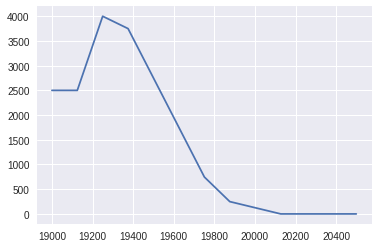

In [17]:
x = np.arange(19000,20500)
plt.plot(x, np.vectorize(payoff)(x), label='sq01w1' )
plt.show()